# Group 14 - Project FP01
## Time series anomaly detection - Isolation Forest Classifier

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import IsolationForest

from dataset import *
from plots import *
from metrics import *
from models_functions import *

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Data Loading

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

file_name_normal = "_20220811_rbtc_"
file_name_collisions = "_collision_20220811_rbtc_"

recording_normal = [0, 2, 3, 4]
recording_collisions = [1, 5]

freq_str = freq.replace(".", "_")
features_folder_normal = f"./features/normal{freq_str}/"
features_folder_collisions = f"./features/collisions{freq_str}/"

### Features Exctraction

In [4]:
df_features_normal, df_normal_raw, _ = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, None)
df_features_collisions, df_collisions_raw, df_collisions_raw_action = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, None)
df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, None)
df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, None)

Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
--- 163.5176043510437 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 58.82421350479126 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


--- 24.114471435546875 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 26.5968017578125 seconds ---


In [5]:
# df_features_normal, df_normal_raw, _ = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, f"{features_folder_normal}")
# df_features_collisions, df_collisions_raw, df_collisions_raw_action = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, f"{features_folder_collisions}1_5/")
# df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, f"{features_folder_collisions}1/")
# df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, f"{features_folder_collisions}5/")

In [6]:
X_train, y_train, X_test, y_test, df_test = get_train_test_data(df_features_normal, df_features_collisions, full_normal=True)
X_train_1, y_train_1, X_test_1, y_test_1, df_test_1 = get_train_test_data(df_features_normal, df_features_collisions_1, full_normal=True)
X_train_5, y_train_5, X_test_5, y_test_5, df_test_5 = get_train_test_data(df_features_normal, df_features_collisions_5, full_normal=True)

### Collisions

In [7]:
collisions_rec1, collisions_init1 = get_collisions('1', ROOTDIR_DATASET_ANOMALY)
collisions_rec5, collisions_init5 = get_collisions('5', ROOTDIR_DATASET_ANOMALY)

# Merge the collisions of the two recordings in one dataframe
collisions_rec = pd.concat([collisions_rec1, collisions_rec5])
collisions_init = pd.concat([collisions_init1, collisions_init5])

In [8]:
collisions_zones, y_collisions = get_collisions_zones_and_labels(collisions_rec, collisions_init, df_features_collisions)
collisions_zones_1, y_collisions_1 = get_collisions_zones_and_labels(collisions_rec1, collisions_init1, df_features_collisions_1)
collisions_zones_5, y_collisions_5 = get_collisions_zones_and_labels(collisions_rec5, collisions_init5, df_features_collisions_5)


## Isolation Forest

In [9]:
#Let's cheat a little bit, computing contamination dircetly on the test set --> By the way in the training set we do not have collisions -.-
cont = np.sum(y_collisions)/float(len(y_collisions))
print(f"dataset contamination = {cont}")

num_estims = [1, 2, 3, 5, 10, 100]
contamination_s = [cont, 0.005, 0.001, 0.001, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
contamination_s += np.linspace(0.03, 0.1, 5).tolist()
clf_s = []
clf_s_1 = []
clf_s_5 = []

#Variare contamination è come variare threshold
for n in num_estims:
    for cont in contamination_s:
        classifier = IsolationForest(
            n_estimators = n,
            contamination = cont
        )
        # Train the RandomForestClassifier on normal data
        classifier.fit(X_train, y_train)
        clf_s.append((classifier, n, cont))

        classifier.fit(X_train_1, y_train_1)
        clf_s_1.append((classifier, n, cont))

        classifier.fit(X_train_5, y_train_5)
        clf_s_5.append((classifier, n, cont))

        print("Random Forest training completed.")


dataset contamination = 0.3431372549019608
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Rando

In [10]:
print(f"Real number of collisions {np.sum(y_collisions == 1)}")
print(f"Real number of collisions {np.sum(y_collisions_1 == 1)}")
print(f"Real number of collisions {np.sum(y_collisions_5 == 1)}")

Real number of collisions 105
Real number of collisions 35
Real number of collisions 56


## Decision function

In [11]:
from sklearn.metrics import f1_score
def compute_decisions(clf_s, X_test, y_collisions):
    best_f1 = 0
    best_model = None
    best_anomaly_scores = None
    for clf in clf_s:
        try:
            anomaly_scores = clf[0].decision_function(X_test)
            # Replace inf values with the maximum float value
            anomaly_scores = np.nan_to_num(anomaly_scores, nan=np.nanmean(anomaly_scores), posinf=np.finfo(float).max, neginf=np.finfo(float).min)
            f1 = f1_score(y_collisions, anomaly_scores < 0)
            if f1 > best_f1:
                best_f1 = f1
                best_model = clf[0]
                best_anomaly_scores = anomaly_scores
        except Exception as e:
            print(f"An error occurred during prediction: {str(e)}")
            # If an error occurs, you might want to inspect the model's internal state
    print("Anomaly prediction completed.")
    return best_model, best_anomaly_scores

In [12]:
best_model, best_anomaly_scores = compute_decisions(clf_s, X_test, y_collisions)
best_model_1, best_anomaly_scores_1 = compute_decisions(clf_s_1, X_test_1, y_collisions_1)
best_model_5, best_anomaly_scores_5 = compute_decisions(clf_s_5, X_test_5, y_collisions_5)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [13]:
def get_statistics(df_test, anomaly_scores, y_collisions, freq):
    anomaly_scores = -anomaly_scores
    y_collisions_predict = anomaly_scores > 0
    df_test['is_collision'] = y_collisions_predict
    df_test['anomaly_score'] = anomaly_scores
    compute_metrics(y_collisions, y_collisions_predict)
    roc_auc = roc_auc_score(y_collisions, anomaly_scores)
    print(f"ROC AUC: {roc_auc}")
    plot_roc_curve(y_collisions, anomaly_scores)
    anomalies_detected = plot_anomalies(anomaly_scores, freq, 0)
    plot_precision_recall_curve(y_collisions, anomaly_scores)
    print(f"Anomalies detected: {anomalies_detected}")
    best_threshold, best_f1, best_precision, best_recall = find_best_threshold(y_collisions, anomaly_scores)
    print(f"Best threshold: {best_threshold:.4f} | F1 Score: {best_f1:.4f} | Precision: {best_precision:.4f} | Recall: {best_recall:.4f}")
    y_collisions_predict_best = sum(anomaly_scores >= best_threshold)
    print(f"Anomalies detected with best threshold: {y_collisions_predict_best}")
    print(f"\n\t-------------------------------------------------------------------------------------\n")
    return df_test

F1 Score: 0.9140
Accuracy: 0.9379
Precision: 0.8707
Recall: 0.9619
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       201
           1       0.87      0.96      0.91       105

    accuracy                           0.94       306
   macro avg       0.92      0.94      0.93       306
weighted avg       0.94      0.94      0.94       306

ROC AUC: 0.940345889599621


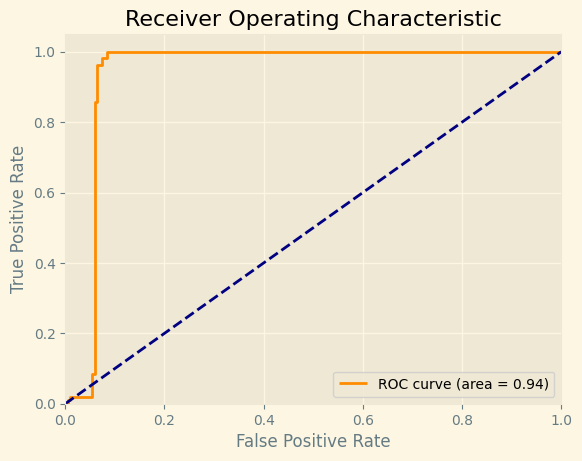

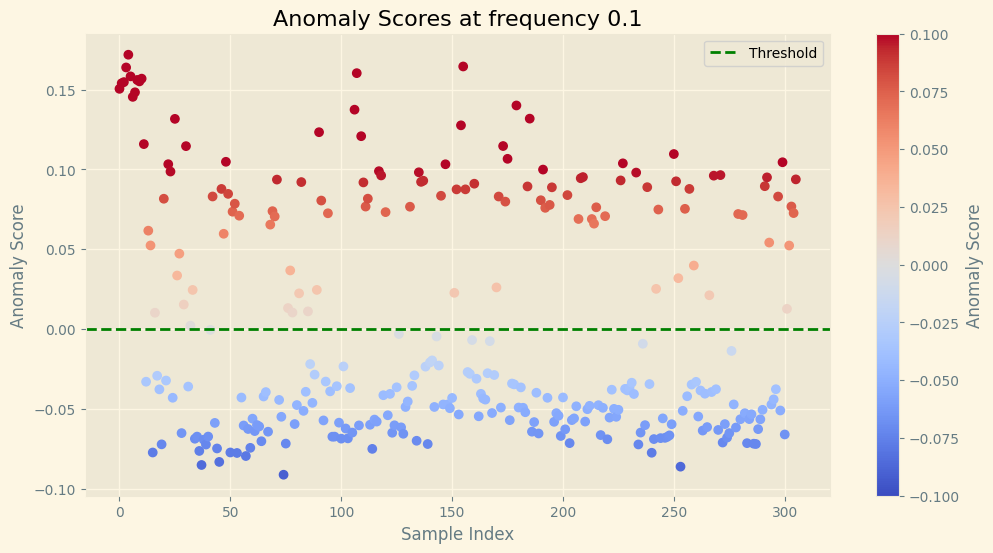

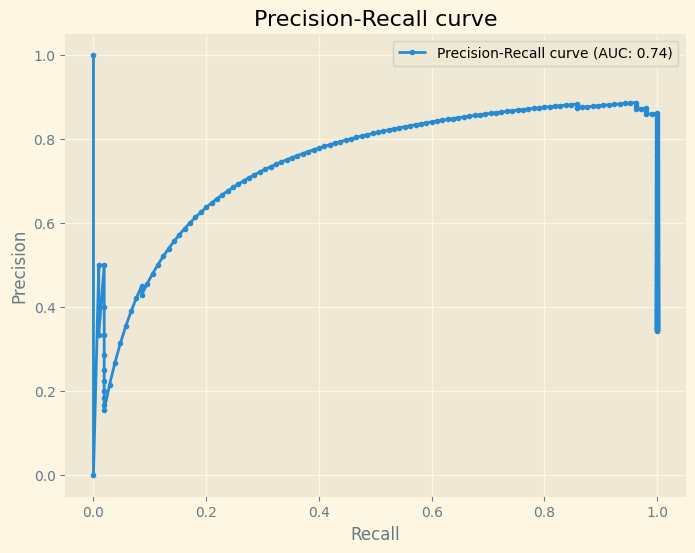

Anomalies detected: 116
Best threshold: -0.0092 | F1 Score: 0.9251 | Precision: 0.8607 | Recall: 1.0000
Anomalies detected with best threshold: 122

	-------------------------------------------------------------------------------------

F1 Score: 0.8732
Accuracy: 0.9451
Precision: 0.8611
Recall: 0.8857
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       129
           1       0.86      0.89      0.87        35

    accuracy                           0.95       164
   macro avg       0.91      0.92      0.92       164
weighted avg       0.95      0.95      0.95       164

ROC AUC: 0.9747508305647841


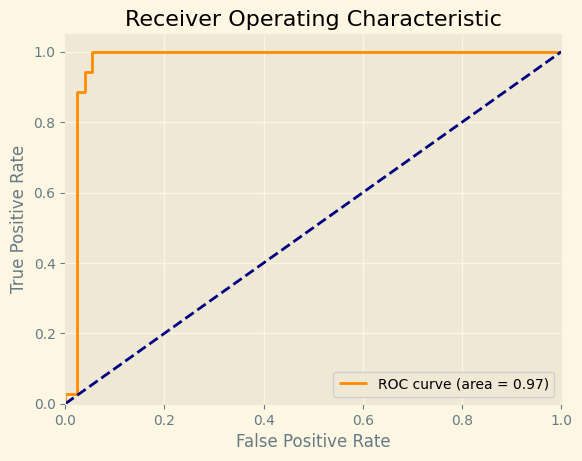

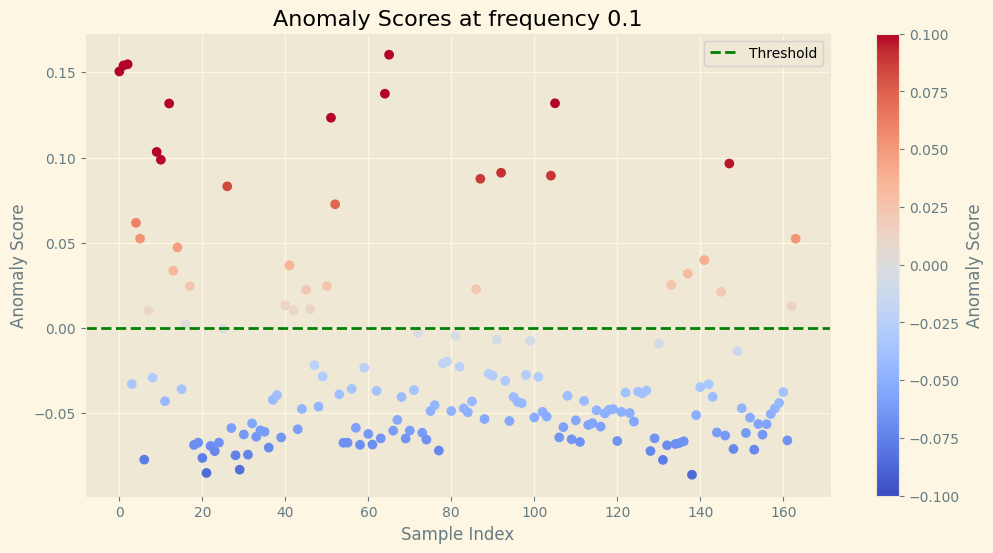

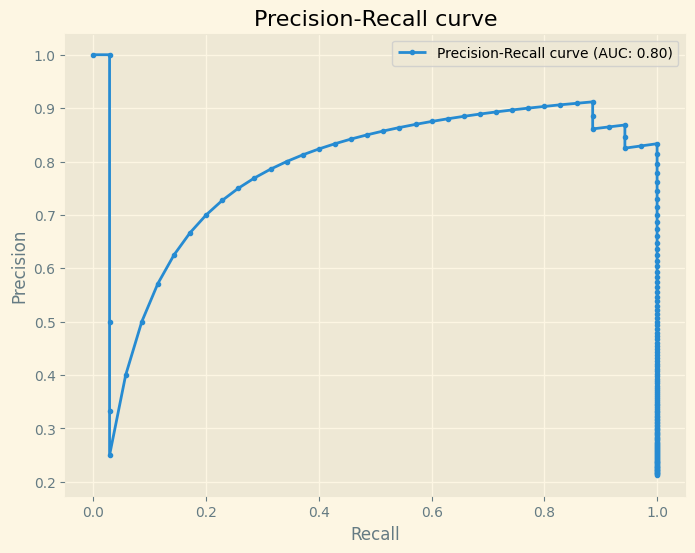

Anomalies detected: 36
Best threshold: -0.0092 | F1 Score: 0.9091 | Precision: 0.8333 | Recall: 1.0000
Anomalies detected with best threshold: 42

	-------------------------------------------------------------------------------------

F1 Score: 0.8296
Accuracy: 0.8369
Precision: 0.7089
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        85
           1       0.71      1.00      0.83        56

    accuracy                           0.84       141
   macro avg       0.85      0.86      0.84       141
weighted avg       0.88      0.84      0.84       141

ROC AUC: 0.8382352941176471


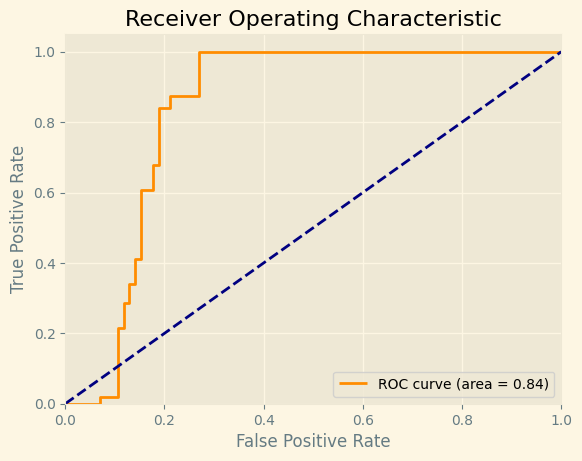

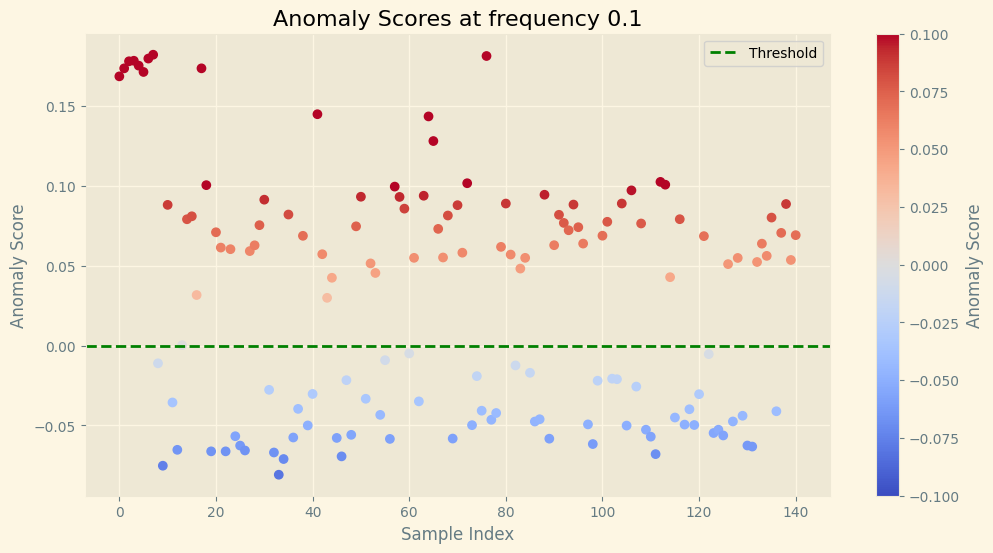

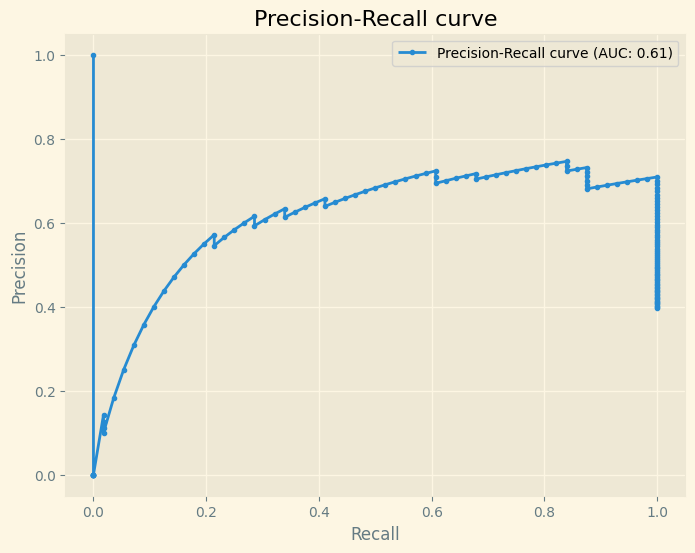

Anomalies detected: 79
Best threshold: 0.0003 | F1 Score: 0.8296 | Precision: 0.7089 | Recall: 1.0000
Anomalies detected with best threshold: 79

	-------------------------------------------------------------------------------------



In [14]:
df_test = get_statistics(df_test, best_anomaly_scores, y_collisions, freq)
df_test_1 = get_statistics(df_test_1, best_anomaly_scores_1, y_collisions_1, freq)
df_test_5 = get_statistics(df_test_5, best_anomaly_scores_5, y_collisions_5, freq)

In [15]:
plot_anomalies_true_and_predicted(df_collisions_raw, df_collisions_raw_action, collisions_zones, df_test, title="Collisions zones vs predicted zones for both recordings")

In [16]:
plot_anomalies_true_and_predicted(df_collisions_raw_1, df_collisions_raw_action_1, collisions_zones_1, df_test_1, title="Collisions zones vs predicted zones for recording 1")

In [17]:
plot_anomalies_true_and_predicted(df_collisions_raw_5, df_collisions_raw_action_5, collisions_zones_5, df_test_5, title="Collisions zones vs predicted zones for recording 5")